In [1]:
%matplotlib inline
import utils
import importlib
importlib.reload(utils)
from utils import *
from __future__ import division, print_function

Using TensorFlow backend.


To get the data from MovieLens
wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [4]:
path = "/data/yinterian/ml-latest-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [5]:
ratings = pd.read_csv(path + 'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [7]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [8]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [9]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [10]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [11]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [12]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [13]:
n_factors = 50

In [14]:
np.random.seed = 42

Randomly split into training and validation. (Question for Jeremy: Should we take the lastest ratings for validation instead?)

In [15]:
msk = np.random.rand(len(ratings)) < 0.8 
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [16]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [17]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [18]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [19]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [20]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [21]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(movie_in)

In [22]:
from keras.layers.merge import Dot
x = Dot(axes=2)([u, m])
x = Flatten()(x)
model = Model(inputs=[user_in, movie_in], outputs=x)
model.compile(Adam(0.001), loss='mse')

In [23]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80072 samples, validate on 19932 samples
Epoch 1/1
80072/80072 [==============================] - 4s - loss: 10.0211 - val_loss: 4.3306

In [24]:
model.optimizer.lr=0.01

In [25]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80072 samples, validate on 19932 samples
Epoch 1/3
80072/80072 [==============================] - 4s - loss: 3.1621 - val_loss: 2.8116

In [26]:
model.optimizer.lr=0.001

In [27]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80072 samples, validate on 19932 samples
Epoch 1/6
80072/80072 [==============================] - 3s - loss: 2.1580 - val_loss: 2.5516

The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

In [28]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         33550                                        
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         453300                                       
___________________________________________________________________________________________

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [29]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

In [30]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [31]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [32]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [34]:
from keras.layers.merge import Add
x = Dot(axes=2)([u, m])
x = Flatten()(x)
x = Add()([x, ub])
x = Add()([x, mb])
model = Model(inputs = [user_in, movie_in], outputs = x)
model.compile(Adam(0.001), loss='mse')

In [35]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80072 samples, validate on 19932 samples
Epoch 1/1
80072/80072 [==============================] - 4s - loss: 8.7187 - val_loss: 3.4648

In [36]:
model.optimizer.lr=0.01

In [65]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80072 samples, validate on 19932 samples
Epoch 1/6
80072/80072 [==============================] - 4s - loss: 0.7368 - val_loss: 1.1340

In [38]:
model.optimizer.lr=0.001

In [39]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80072 samples, validate on 19932 samples
Epoch 1/10
80072/80072 [==============================] - 4s - loss: 1.5301 - val_loss: 1.7357

In [40]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80072 samples, validate on 19932 samples
Epoch 1/5
80072/80072 [==============================] - 4s - loss: 0.9242 - val_loss: 1.2669

This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [41]:
model.save_weights(model_path+'bias.h5')

In [42]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [43]:
model.predict([np.array([3]), np.array([6])])

array([[ 5.0257]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [44]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [45]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [46]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.52914673, 'Battlefield Earth (2000)'),
 (-0.15007074, 'Super Mario Bros. (1993)'),
 (-0.10318322, 'Jaws 3-D (1983)'),
 (-0.077007793, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (-0.075768098, 'Speed 2: Cruise Control (1997)'),
 (-0.025009774, 'Bio-Dome (1996)'),
 (-0.010553629, 'Little Nicky (2000)'),
 (-0.0044470653, 'Blade: Trinity (2004)'),
 (0.025525646, 'Scary Movie 2 (2001)'),
 (0.03683288, 'Spice World (1997)'),
 (0.038814127, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (0.068649285, 'Batman & Robin (1997)'),
 (0.076068446, 'Blair Witch Project, The (1999)'),
 (0.089047313, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.094347157, 'Mission to Mars (2000)')]

In [47]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.38686, 'Her (2013)'),
 (1.3674535, 'Rush (2013)'),
 (1.3326193, 'Argo (2012)'),
 (1.3262814, 'Shawshank Redemption, The (1994)'),
 (1.3163332, 'Tom Jones (1963)'),
 (1.3055105, 'My Neighbor Totoro (Tonari no Totoro) (1988)'),
 (1.3036822, 'Ideal Husband, An (1999)'),
 (1.2856315, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.2827923, 'Exotica (1994)'),
 (1.2801174, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.27906, 'Cyrano de Bergerac (1990)'),
 (1.272404, 'Captain America: The Winter Soldier (2014)'),
 (1.2536759, 'Coming Home (1978)'),
 (1.2382356, 'On the Waterfront (1954)'),
 (1.2282454, 'Harry Potter and the Half-Blood Prince (2009)')]

We can now do the same thing for the embeddings.

In [48]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [49]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [50]:
fac0 = movie_pca[0]

In [51]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [52]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.051536311803936662, 'Toy Story (1995)'),
 (0.049012236453692952, 'Matrix, The (1999)'),
 (0.048438064810870977, 'American Beauty (1999)'),
 (0.047913834346814427, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (0.047567888615680294, 'Eternal Sunshine of the Spotless Mind (2004)'),
 (0.047429091430819824, 'Clerks (1994)'),
 (0.047322299884700034, 'Godfather, The (1972)'),
 (0.047122985254459016, 'Donnie Darko (2001)'),
 (0.046782789251664444, 'American History X (1998)'),
 (0.046497568507207779, 'Godfather: Part II, The (1974)')]

In [53]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.013773727378789714, 'Anaconda (1997)'),
 (-0.013603421330461635, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.0098737124491087378, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.0093896858198349899, 'RoboCop 3 (1993)'),
 (-0.0093745868274132515, 'Children of the Corn (1984)'),
 (-0.0076664248121051286, 'Fantastic Four (2005)'),
 (-0.0075161168790739592, 'Howard the Duck (1986)'),
 (-0.0072026816420900173, 'Blade: Trinity (2004)'),
 (-0.0070214590509942859, 'Battlefield Earth (2000)'),
 (-0.0067355250429308429,
  'Highlander III: The Sorcerer (a.k.a. Highlander: The Final Dimension) (1994)')]

In [54]:
fac1 = movie_pca[1]

In [55]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [56]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.062273029586017402, 'City Lights (1931)'),
 (0.058010052624987471, 'Apocalypse Now (1979)'),
 (0.057187136886130606, 'Clockwork Orange, A (1971)'),
 (0.054251393978061599, 'Annie Hall (1977)'),
 (0.053855969644539009, 'Royal Tenenbaums, The (2001)'),
 (0.053666196268393231, '2001: A Space Odyssey (1968)'),
 (0.053210678746938217, "Miller's Crossing (1990)"),
 (0.052583836613077348, 'Wild Bunch, The (1969)'),
 (0.052032789642478636, '8 1/2 (8½) (1963)'),
 (0.050814934003450198, 'Brokeback Mountain (2005)')]

In [57]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.10286175138427059, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.080427648769346494, 'Armageddon (1998)'),
 (-0.080023896043659198, 'Stargate (1994)'),
 (-0.077202671615199253, 'Titanic (1997)'),
 (-0.075034842604976087, 'Speed (1994)'),
 (-0.071170000230734651, 'Cliffhanger (1993)'),
 (-0.070985175857080557, 'Rock, The (1996)'),
 (-0.070949839331683057, 'Austin Powers in Goldmember (2002)'),
 (-0.069030602648318728, 'Batman Forever (1995)'),
 (-0.067861406657793874, 'Ace Ventura: Pet Detective (1994)')]

In [58]:
fac2 = movie_pca[2]

In [59]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [60]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.14007604267139068, 'Silence of the Lambs, The (1991)'),
 (0.13045128570327419, 'Seven (a.k.a. Se7en) (1995)'),
 (0.11120381808977435, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (0.086195012559395406, 'Fargo (1996)'),
 (0.081386590381312268, 'Dances with Wolves (1990)'),
 (0.077682428956345334, 'Braveheart (1995)'),
 (0.077455617301467883, '2001: A Space Odyssey (1968)'),
 (0.076808568591935369, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.075349401783197864, 'Terminator 2: Judgment Day (1991)'),
 (0.074457403547432854, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)')]

In [61]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.069326187653726959, 'Chicken Run (2000)'),
 (-0.068006212970829732, 'Chicago (2002)'),
 (-0.061375575320390702, 'Legally Blonde (2001)'),
 (-0.061342877852887272, 'Bend It Like Beckham (2002)'),
 (-0.059947529943246258, 'Sabrina (1995)'),
 (-0.059664477145083807,
  'Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)'),
 (-0.057564574969855002, 'Tangled (2010)'),
 (-0.057417414951636173, '13 Going on 30 (2004)'),
 (-0.056012620880165925, 'Blind Side, The  (2009)'),
 (-0.055726530047089128, 'Elf (2003)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

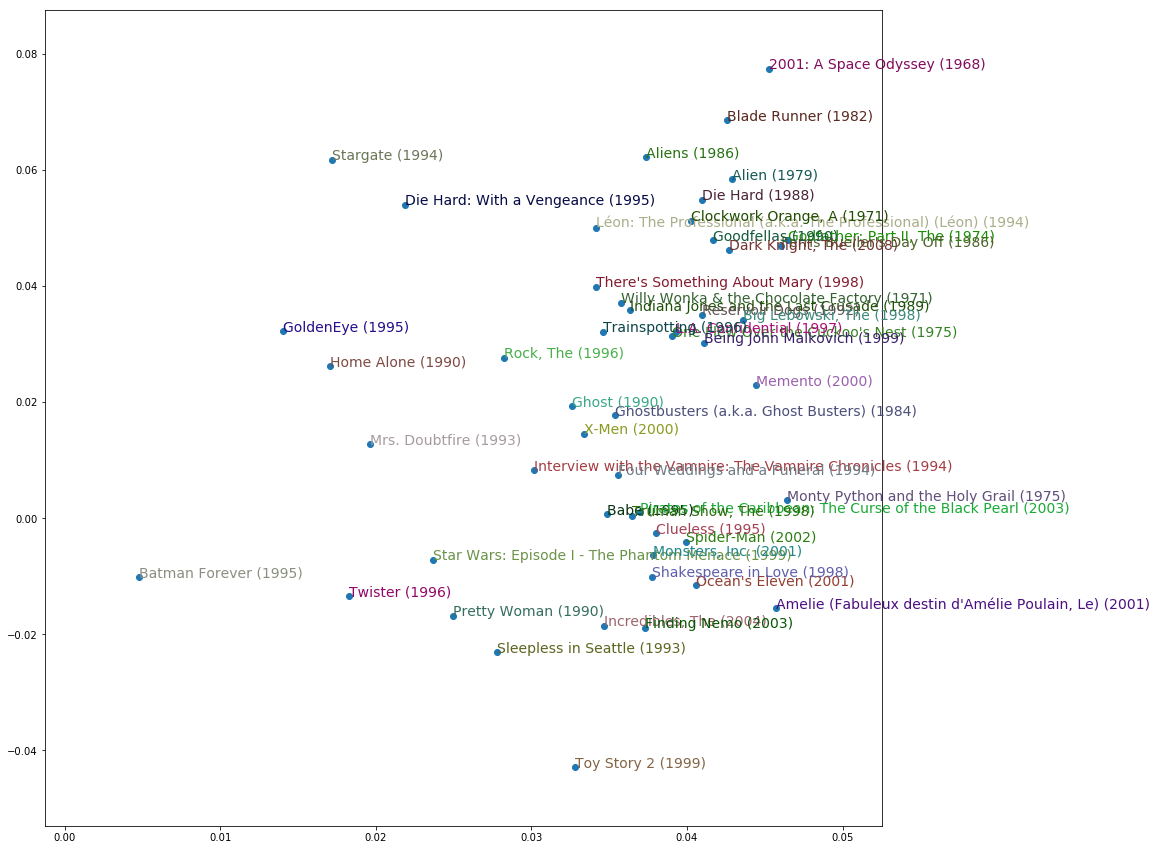

In [63]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [64]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [69]:
from keras.layers.merge import Concatenate
x = Concatenate()([u, m])
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [70]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80072 samples, validate on 19932 samples
Epoch 1/8
80072/80072 [==============================] - 6s - loss: 2.3264 - val_loss: 0.8967

This improves on our already impressive accuracy even further!